In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
import os
os.chdir('/content/drive/My Drive/Advanced CV/UNet')
path = '.'

In [0]:
pwd

'/content/drive/My Drive/Advanced CV/UNet'

In [0]:
#Image Settings -

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

In [0]:
#Getting the image list 

mylist  = os.listdir('/content/drive/My Drive/Advanced CV/UNet/images')

In [0]:
print(mylist)

['newfoundland_177.png', 'pomeranian_120.png', 'american_pit_bull_terrier_31.png', 'keeshond_88.png', 'german_shorthaired_173.png', 'Persian_262.png', 'english_setter_130.jpg', 'american_pit_bull_terrier_118.jpg', 'Ragdoll_121.png', 'Maine_Coon_78.png', 'Maine_Coon_91.jpg', 'saint_bernard_146.jpg', 'Egyptian_Mau_63.jpg', 'Abyssinian_37.png', 'shiba_inu_28.jpg', 'Siamese_104.jpg', 'american_pit_bull_terrier_127.png', 'staffordshire_bull_terrier_90.jpg', 'newfoundland_188.jpg', 'Ragdoll_75.png', 'boxer_77.png', 'havanese_184.png', 'Birman_19.png', 'wheaten_terrier_20.jpg', 'chihuahua_127.jpg', 'havanese_190.png', 'saint_bernard_150.jpg', 'Birman_25.jpg', 'Egyptian_Mau_88.jpg', 'Russian_Blue_212.png', 'saint_bernard_39.jpg', 'keeshond_63.png', 'Bengal_1.png', 'american_bulldog_139.png', 'german_shorthaired_8.jpg', 'Sphynx_239.jpg', 'staffordshire_bull_terrier_41.png', 'Bengal_33.png', 'newfoundland_8.png', 'yorkshire_terrier_64.png', 'Persian_260.jpg', 'japanese_chin_42.png', 'american_bu

In [0]:
#Separating  mask and images 
masks = []
original = []
for filename in mylist:
    if filename.endswith('.png'):
        masks.append(filename)
    if filename.endswith('.jpg'):
        original.append(filename)

In [0]:
#Sorting
original.sort()
masks.sort()
num = 1000 ### Restricting the images to 1000 for classroom purposes. Larger no of images takes longer time to execute
original = original[:num]
masks = masks[:num]

In [0]:
original[0]

'Abyssinian_1.jpg'

In [0]:
#Checkout image names
print(original[-1])
print(masks[-1])
print(original[1])
print(masks[1])


Egyptian_Mau_1.jpg
Egyptian_Mau_1.png
Abyssinian_10.jpg
Abyssinian_10.png


In [0]:
import cv2
import matplotlib.pyplot as plt

In [0]:
#Get the data -  X and y
from PIL import Image
import numpy as np
y = np.zeros((len(masks), HEIGHT_CELLS, WIDTH_CELLS), dtype=np.float32)
X = np.zeros((len(original), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

for file in original:
    n = original.index(file)
    path1 = os.path.join('/content/drive/My Drive/Advanced CV/UNet/images', file)
    #path1 = './images/Abyssinian_34.jpg'
    img = Image.open(path1)
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.reshape(img.convert('L'), (224,224,1)) ## Converting the image to greyscale # Minimizing the parameters
    X[n] = img
    file2 = masks[n]
    #n = masks.index(file)
    path2 = os.path.join('/content/drive/My Drive/Advanced CV/UNet/images/', file2)
    # Load images
    mask = cv2.imread(path2)
    mask = (mask!=2)*1.0  
    mask = cv2.resize(mask, (28, 28))
    mask = 1.0*(mask[:,:,0]>0.2)
    y[n] = mask
    #print(n,)

In [0]:
#Check the data
print(X.shape)
print(y.shape)

(1000, 224, 224, 1)
(1000, 28, 28)


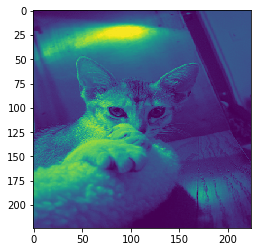

In [0]:
#Check the images
plt.imshow(X[1].squeeze())


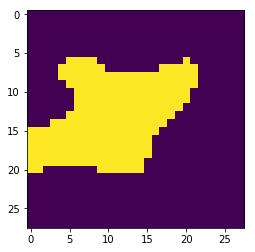

In [0]:
plt.imshow(y[1])

In [0]:
#Install segmentation models
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-xn2ggfrn
  Stored in directory: /tmp/pip-ephem-wheel-cache-f3lgb43j/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
#Import libraries
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

In [0]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [0]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [0]:
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)

In [0]:
x_val.shape

(150, 224, 224, 1)

In [0]:
x_train.shape

(850, 224, 224, 1)

In [0]:
y_train.shape

(850, 28, 28)

In [0]:
y_valid.shape

(150, 28, 28)

In [0]:
#Build your model 
from keras.layers import Reshape
N = x_train.shape[-1]

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(224, 224, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(out)
x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(x)
x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(x)
x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

model = Model(inp, x, name=base_model.name)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 3)       6         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24456154  
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 1)       5         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 1)         5         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         5         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total para

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [0]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
# compile model
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [0]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,    
    epochs=20,
    validation_data=(x_val, y_valid)
)

Train on 850 samples, validate on 150 samples
Epoch 1/20
850/850 [==============================] - 12s 14ms/step - loss: 0.9316 - dice_coefficient: 0.6165 - val_loss: 0.9889 - val_dice_coefficient: 0.5956
Epoch 2/20
850/850 [==============================] - 12s 14ms/step - loss: 0.9036 - dice_coefficient: 0.6256 - val_loss: 0.9745 - val_dice_coefficient: 0.5999
Epoch 3/20
850/850 [==============================] - 12s 14ms/step - loss: 0.8812 - dice_coefficient: 0.6331 - val_loss: 0.9594 - val_dice_coefficient: 0.6065
Epoch 4/20
850/850 [==============================] - 12s 15ms/step - loss: 0.8532 - dice_coefficient: 0.6427 - val_loss: 0.9598 - val_dice_coefficient: 0.6122
Epoch 5/20
850/850 [==============================] - 12s 14ms/step - loss: 0.8230 - dice_coefficient: 0.6528 - val_loss: 0.9183 - val_dice_coefficient: 0.6183
Epoch 6/20
850/850 [==============================] - 12s 14ms/step - loss: 0.8005 - dice_coefficient: 0.6605 - val_loss: 1.0867 - val_dice_coefficient: 0

In [0]:
model.evaluate(x_val, y_valid, verbose=1)

150/150 [==============================] - 1s 5ms/step


[0.6069157894452413, 0.7374195226033529]

In [0]:
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)
import numpy as np

150/150 [==============================] - 1s 4ms/step


In [0]:
#Save weights
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='hot')
    if has_mask:
        ax[0].contour(y[ix].squeeze())
    ax[0].set_title('cat')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze())
    if has_mask:
        ax[2].contour(preds[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('mask Predicted')
    

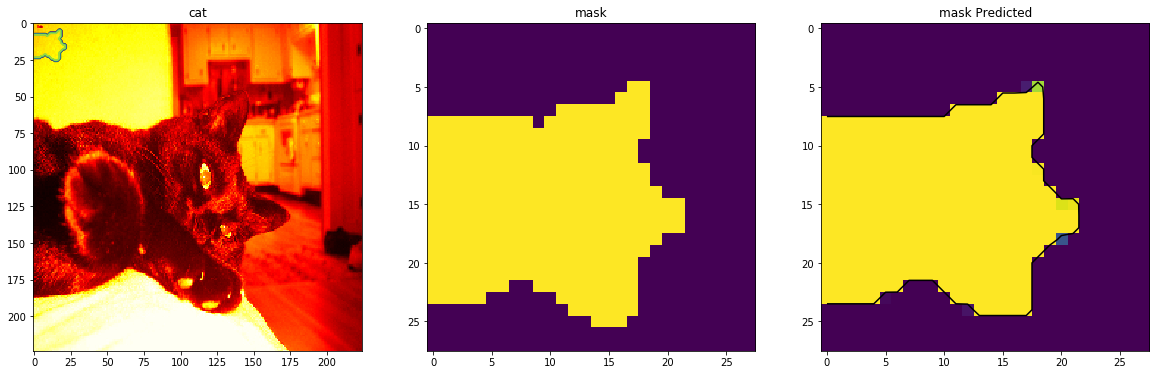

In [0]:
# Check if training data looks all right
plot_sample(x_train, y_train, preds_train)

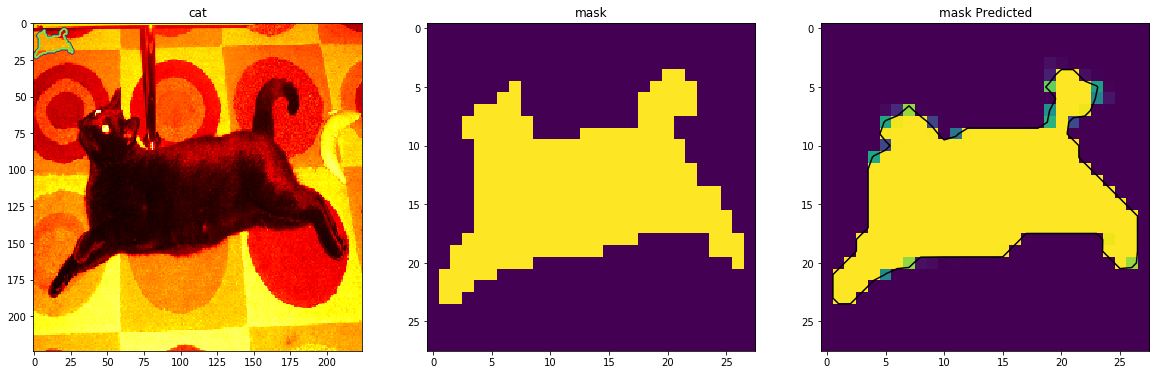

In [0]:
# Check if valid data looks all right
plot_sample(x_val, y_valid, preds_val)